In [70]:
# Reiniciar e limpar a memória do Colab
%reset -f

In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [72]:
data = pd.read_csv('insurance.csv')
data_novos_clientes = pd.read_excel('novos_clientes.xlsx')

In [73]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [74]:
data_novos_clientes.head()

,age,sex,bmi,children,smoker,region
0,50,female,26.22,0,no,northwest
1,30,female,41.22,5,yes,southeast
2,29,female,51.32,0,yes,southeast
3,53,female,44.50,1,yes,northeast
4,55,male,26.22,4,no,southwest


In [75]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [76]:
missing_per_column = data.isnull().sum
missing_percentage = (data.isnull().sum() / len(data)) * 100
print(missing_percentage)

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64


In [77]:
# Separar os inputs e outputs do dataset "data"
X = data.drop(columns=['charges'])  # Inputs: todas as colunas exceto 'charges'
y = data['charges']                 # Output: coluna 'charges'

# Os dados de novos clientes já são apenas inputs
X_novos_clientes = data_novos_clientes

In [78]:
# Dividir os dados em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar os tamanhos dos conjuntos
print("Tamanho do treino:", X_train.shape)
print("Tamanho do teste:", X_test.shape)

Tamanho do treino: (1070, 6)
Tamanho do teste: (268, 6)


In [79]:
X_train.head()

,age,sex,bmi,children,smoker,region
560,46,female,19.95,2,no,northwest
1285,47,female,24.32,0,no,northeast
1142,52,female,24.86,0,no,southeast
969,39,female,34.32,5,no,southeast
486,54,female,21.47,3,no,northwest


In [80]:
X_test.head()

,age,sex,bmi,children,smoker,region
764,45,female,25.175,2,no,northeast
887,36,female,30.020,0,no,northwest
890,64,female,26.885,0,yes,northwest
1293,46,male,25.745,3,no,northwest
259,19,male,31.920,0,yes,northwest


In [81]:
X_novos_clientes.head()

,age,sex,bmi,children,smoker,region
0,50,female,26.22,0,no,northwest
1,30,female,41.22,5,yes,southeast
2,29,female,51.32,0,yes,southeast
3,53,female,44.50,1,yes,northeast
4,55,male,26.22,4,no,southwest


In [82]:
# Selecionar apenas as colunas categóricas e numéricas como listas
categorical_columns = list(X_train.select_dtypes(include=['object', 'category']).columns)
numerical_columns = list(X_train.select_dtypes(include=['int64', 'float64']).columns)

# Criar um dicionário com valores distintos de cada coluna categórica para verificação das possibilidades
distinct_dict = {col: data[col].unique().tolist() for col in categorical_columns}

# Mostrar o dicionário na vertical
for key, values in distinct_dict.items():
    print(f"{key}: {values}")

sex: ['female', 'male']
smoker: ['yes', 'no']
region: ['southwest', 'southeast', 'northwest', 'northeast']


In [83]:
# Criar o transformador com OneHotEncoder para colunas categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_columns)
    ],
    remainder='passthrough'  # Mantém as colunas numéricas sem alterações
)

# Aplicar o transformador
X_train_numerical = preprocessor.fit_transform(X_train)
X_test_numerical = preprocessor.transform(X_test)
X_novos_clientes_numerical = preprocessor.transform(X_novos_clientes)

# Obter os nomes das colunas transformadas
encoded_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
final_columns = list(encoded_columns) + numerical_columns

# Criar DataFrames para visualização
X_train_df = pd.DataFrame(X_train_numerical, columns=final_columns)
X_test_df = pd.DataFrame(X_test_numerical, columns=final_columns)
X_novos_clientes_df = pd.DataFrame(X_novos_clientes_numerical, columns=final_columns)

In [84]:
from sklearn.pipeline import Pipeline

# Primeiro faz o OneHotEncoding nas categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_columns)
    ],
    remainder='passthrough'  # Mantém as numéricas sem alteração inicial
)

# Cria um pipeline que primeiro aplica o ColumnTransformer e depois escala tudo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())  # Ou MinMaxScaler()
])

# Aplicar o pipeline
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)
X_novos_clientes_processed = pipeline.transform(X_novos_clientes)

# Obter os nomes das colunas (após OneHotEncoder)
cat_encoded_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_columns)
final_columns = list(cat_encoded_columns) + numerical_columns

# Observação: Se aplicou o scaler em tudo, os valores estarão padronizados, mas os nomes das colunas permanecem

In [85]:
X_train_df.head()

,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age,bmi,children
0,0.0,0.0,1.0,0.0,0.0,46.0,19.95,2.0
1,0.0,0.0,0.0,0.0,0.0,47.0,24.32,0.0
2,0.0,0.0,0.0,1.0,0.0,52.0,24.86,0.0
3,0.0,0.0,0.0,1.0,0.0,39.0,34.32,5.0
4,0.0,0.0,1.0,0.0,0.0,54.0,21.47,3.0


In [86]:
X_novos_clientes_df.head()

,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age,bmi,children
0,0.0,0.0,1.0,0.0,0.0,50.0,26.22,0.0
1,0.0,1.0,0.0,1.0,0.0,30.0,41.22,5.0
2,0.0,1.0,0.0,1.0,0.0,29.0,51.32,0.0
3,0.0,1.0,0.0,0.0,0.0,53.0,44.50,1.0
4,1.0,0.0,0.0,0.0,1.0,55.0,26.22,4.0


In [87]:
X_train_processed

array([[-1.0246016 , -0.50874702,  1.78316783, ...,  0.47222651,
        -1.75652513,  0.73433626],
       [-1.0246016 , -0.50874702, -0.56079971, ...,  0.54331294,
        -1.03308239, -0.91119211],
       [-1.0246016 , -0.50874702, -0.56079971, ...,  0.8987451 ,
        -0.94368672, -0.91119211],
       ...,
       [ 0.97598911, -0.50874702, -0.56079971, ...,  1.3252637 ,
        -0.89153925, -0.91119211],
       [-1.0246016 ,  1.96561348, -0.56079971, ..., -0.16755139,
         2.82086429,  0.73433626],
       [ 0.97598911, -0.50874702, -0.56079971, ...,  1.1120044 ,
        -0.10932713, -0.91119211]])

In [88]:
# Converter o array de volta para DataFrame
X_train_df = pd.DataFrame(
    X_train_processed,  # Array NumPy
    columns=final_columns,  # Nomes das colunas que você já extraiu
    index=X_train.index  # Opcional: mantém os índices originais do X_train
)
# Converter o array de volta para DataFrame
X_test_df = pd.DataFrame(
    X_test_processed,  # Array NumPy
    columns=final_columns,  # Nomes das colunas que você já extraiu
    index=X_test.index  # Opcional: mantém os índices originais do X_train
)

X_novos_clientes_df = pd.DataFrame(
    X_novos_clientes_processed,  # Array NumPy
    columns=final_columns,  # Nomes das colunas que você já extraiu
    index=X_novos_clientes.index  # Opcional: mantém os índices originais do X_train
)

In [89]:
X_train_df.head()

,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age,bmi,children
560,-1.024602,-0.508747,1.783168,-0.599661,-0.572314,0.472227,-1.756525,0.734336
1285,-1.024602,-0.508747,-0.560800,-0.599661,-0.572314,0.543313,-1.033082,-0.911192
1142,-1.024602,-0.508747,-0.560800,1.667609,-0.572314,0.898745,-0.943687,-0.911192
969,-1.024602,-0.508747,-0.560800,1.667609,-0.572314,-0.025379,0.622393,3.202629
486,-1.024602,-0.508747,1.783168,-0.599661,-0.572314,1.040918,-1.504893,1.557100


In [90]:
X_test_df.head()

,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age,bmi,children
764,-1.024602,-0.508747,-0.560800,-0.599661,-0.572314,0.401140,-0.891539,0.734336
887,-1.024602,-0.508747,1.783168,-0.599661,-0.572314,-0.238638,-0.089461,-0.911192
890,-1.024602,1.965613,1.783168,-0.599661,-0.572314,1.751782,-0.608453,-0.911192
1293,0.975989,-0.508747,1.783168,-0.599661,-0.572314,0.472227,-0.797177,1.557100
259,0.975989,1.965613,1.783168,-0.599661,-0.572314,-1.447107,0.225079,-0.911192


In [91]:
X_novos_clientes_df.head()

,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age,bmi,children
0,-1.024602,-0.508747,1.783168,-0.599661,-0.572314,0.756572,-0.718542,-0.911192
1,-1.024602,1.965613,-0.560800,1.667609,-0.572314,-0.665156,1.764671,3.202629
2,-1.024602,1.965613,-0.560800,1.667609,-0.572314,-0.736243,3.436701,-0.911192
3,-1.024602,1.965613,-0.560800,-0.599661,-0.572314,0.969832,2.307667,-0.088428
4,0.975989,-0.508747,-0.560800,-0.599661,1.747292,1.112004,-0.718542,2.379865


In [92]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definindo os grids de parâmetros para cada modelo
models = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}
    },
    "Ridge Regression": {
        "model": Ridge(),
        "params": {
            'alpha': [0.1, 1, 10],
            'solver': ['auto', 'svd']
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1]
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            'kernel': ['rbf', 'linear'],
            'C': [0.1, 1, 10],
            'epsilon': [0.01, 0.1]
        }
    },
    "Polynomial Regression (deg=2)": {
        "model": Pipeline([
            ('poly', PolynomialFeatures(degree=2)),
            ('linear', LinearRegression())
        ]),
        "params": {
            'linear__fit_intercept': [True, False]
        }
    }
}

# Avaliação com GridSearch
results = []

for model_name, config in models.items():
    print(f"\n=== Tunando {model_name} ===")

    grid = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    # Usando X_train_df e X_test_df diretamente (já pré-processados)
    grid.fit(X_train_df, y_train)

    # Melhores parâmetros
    best_params = grid.best_params_

    # Predições com o melhor modelo
    y_pred = grid.predict(X_test_df)

    # Métricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Modelo': model_name,
        'Melhores Parâmetros': best_params,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })

# Exibindo resultados comparativos
print("\n=== RESULTADOS FINAIS ===")
print(f"{'Modelo':<25} | {'MAE':<10} | {'RMSE':<10} | {'R²':<8} | Melhores Parâmetros")
print("="*85)
for res in results:
    print(f"{res['Modelo']:<25} | {res['MAE']:<10.2f} | {res['RMSE']:<10.2f} | {res['R²']:<8.4f} | {str(res['Melhores Parâmetros'])}")

# Criando DataFrame com os resultados para análise
resultados_df = pd.DataFrame(results)


=== Tunando Linear Regression ===

=== Tunando Ridge Regression ===

=== Tunando Random Forest ===

=== Tunando XGBoost ===

=== Tunando SVR ===

=== Tunando Polynomial Regression (deg=2) ===

=== RESULTADOS FINAIS ===
Modelo                    | MAE        | RMSE       | R²       | Melhores Parâmetros
Linear Regression         | 4181.19    | 5796.28    | 0.7836   | {}
Ridge Regression          | 4182.80    | 5796.98    | 0.7835   | {'alpha': 1, 'solver': 'svd'}
Random Forest             | 2533.58    | 4496.86    | 0.8697   | {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
XGBoost                   | 2440.07    | 4254.78    | 0.8834   | {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
SVR                       | 4187.09    | 8747.65    | 0.5071   | {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}
Polynomial Regression (deg=2) | 2729.50    | 4551.13    | 0.8666   | {'linear__fit_intercept': True}


In [93]:
X_train_df

,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age,bmi,children
560,-1.024602,-0.508747,1.783168,-0.599661,-0.572314,0.472227,-1.756525,0.734336
1285,-1.024602,-0.508747,-0.560800,-0.599661,-0.572314,0.543313,-1.033082,-0.911192
1142,-1.024602,-0.508747,-0.560800,1.667609,-0.572314,0.898745,-0.943687,-0.911192
969,-1.024602,-0.508747,-0.560800,1.667609,-0.572314,-0.025379,0.622393,3.202629
486,-1.024602,-0.508747,1.783168,-0.599661,-0.572314,1.040918,-1.504893,1.557100
...,...,...,...,...,...,...,...,...
1095,-1.024602,-0.508747,-0.560800,-0.599661,-0.572314,-1.518194,0.130717,2.379865
1130,-1.024602,-0.508747,-0.560800,1.667609,-0.572314,-0.025379,-1.107579,3.202629
1294,0.975989,-0.508747,-0.560800,-0.599661,-0.572314,1.325264,-0.891539,-0.911192
860,-1.024602,1.965613,-0.560800,-0.599661,1.747292,-0.167551,2.820864,0.734336


=== FASE 1: Otimizando learning_rate e n_estimators ===
Melhor learning_rate: 0.2 (RMSE: 4624.7147)

=== FASE 2: Otimizando estrutura da árvore ===
Melhor max_depth: 2
Melhor min_child_weight: 3

=== FASE 3: Otimizando parâmetros de regularização ===
Melhor gamma: 0
Melhor reg_alpha: 0
Melhor reg_lambda: 0

Treinando modelo final com os melhores parâmetros...
[0]	Test-rmse:10502.65080
[50]	Test-rmse:4229.89161
[69]	Test-rmse:4234.02119

=== RESULTADOS FINAIS ===
MAE: 2337.14
RMSE: 4234.02
R²: 0.8845

=== COMPARAÇÃO ===
MAE original: 2440.07 | Otimizado: 2337.14
RMSE original: 4254.78 | Otimizado: 4234.02
R² original: 0.8834 | Otimizado: 0.8845


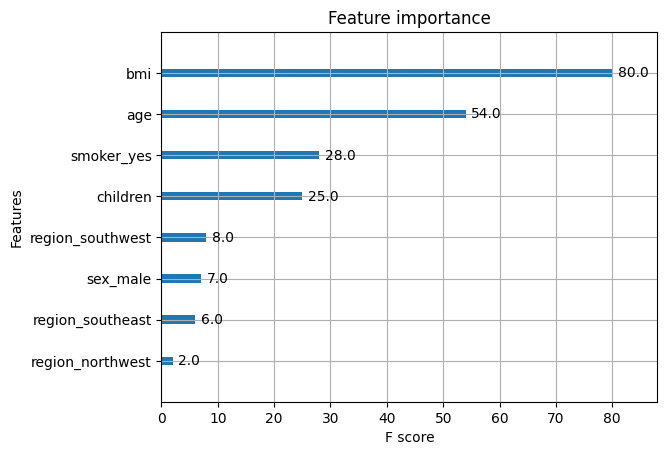

In [94]:
import matplotlib.pyplot as plt  # Adicione esta linha no início do código
import xgboost as xgb

## 1. Converter dados para formato DMatrix (mais eficiente para XGBoost)
dtrain = xgb.DMatrix(X_train_df, label=y_train)
dtest = xgb.DMatrix(X_test_df, label=y_test)

## 2. Primeira Fase: Otimizar learning_rate e n_estimators
print("=== FASE 1: Otimizando learning_rate e n_estimators ===")

# Parâmetros base
params = {
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42
}

# Busca do melhor learning_rate
best_score = float('inf')
best_lr = None

for lr in [0.01, 0.05, 0.1, 0.15, 0.2]:
    params['learning_rate'] = lr
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=500,
        nfold=3,
        early_stopping_rounds=20,
        verbose_eval=False
    )
    rmse = cv_results['test-rmse-mean'].min()

    if rmse < best_score:
        best_score = rmse
        best_lr = lr

print(f"Melhor learning_rate: {best_lr} (RMSE: {best_score:.4f})")

## 3. Segunda Fase: Otimizar estrutura da árvore
print("\n=== FASE 2: Otimizando estrutura da árvore ===")

params['learning_rate'] = best_lr
best_params = params.copy()

# Testando combinações de max_depth e min_child_weight
for depth in [2, 3, 4, 5]:
    for child_weight in [1, 3, 5]:
        params['max_depth'] = depth
        params['min_child_weight'] = child_weight

        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=500,
            nfold=3,
            early_stopping_rounds=20,
            verbose_eval=False
        )
        rmse = cv_results['test-rmse-mean'].min()

        if rmse < best_score:
            best_score = rmse
            best_params.update({
                'max_depth': depth,
                'min_child_weight': child_weight
            })

print(f"Melhor max_depth: {best_params['max_depth']}")
print(f"Melhor min_child_weight: {best_params['min_child_weight']}")

## 4. Terceira Fase: Regularização
print("\n=== FASE 3: Otimizando parâmetros de regularização ===")

for gamma in [0, 0.1, 0.2]:
    for reg_alpha in [0, 0.1, 1]:
        for reg_lambda in [0, 0.1, 1]:
            params.update({
                'gamma': gamma,
                'reg_alpha': reg_alpha,
                'reg_lambda': reg_lambda
            })

            cv_results = xgb.cv(
                params,
                dtrain,
                num_boost_round=500,
                nfold=3,
                early_stopping_rounds=20,
                verbose_eval=False
            )
            rmse = cv_results['test-rmse-mean'].min()

            if rmse < best_score:
                best_score = rmse
                best_params.update({
                    'gamma': gamma,
                    'reg_alpha': reg_alpha,
                    'reg_lambda': reg_lambda
                })

print(f"Melhor gamma: {best_params.get('gamma', 0)}")
print(f"Melhor reg_alpha: {best_params.get('reg_alpha', 0)}")
print(f"Melhor reg_lambda: {best_params.get('reg_lambda', 0)}")

## 5. Treinar modelo final
print("\nTreinando modelo final com os melhores parâmetros...")
final_model = xgb.train(
    best_params,
    dtrain,
    num_boost_round=500,
    evals=[(dtest, "Test")],
    early_stopping_rounds=20,
    verbose_eval=50
)

## 6. Avaliação
y_pred = final_model.predict(dtest)

print("\n=== RESULTADOS FINAIS ===")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

## 7. Comparação com o original
print("\n=== COMPARAÇÃO ===")
print(f"MAE original: 2440.07 | Otimizado: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE original: 4254.78 | Otimizado: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R² original: 0.8834 | Otimizado: {r2_score(y_test, y_pred):.4f}")

## 8. Visualização da importância das features
xgb.plot_importance(final_model, max_num_features=10)
plt.show()


=== ANÁLISE DAS PREVISÕES ===
count    15000.000000
mean     22376.113281
std      15427.794922
min        824.729004
25%       9087.385742
50%      16930.337891
75%      40318.511719
max      53744.703125
Name: charges_predito, dtype: float64


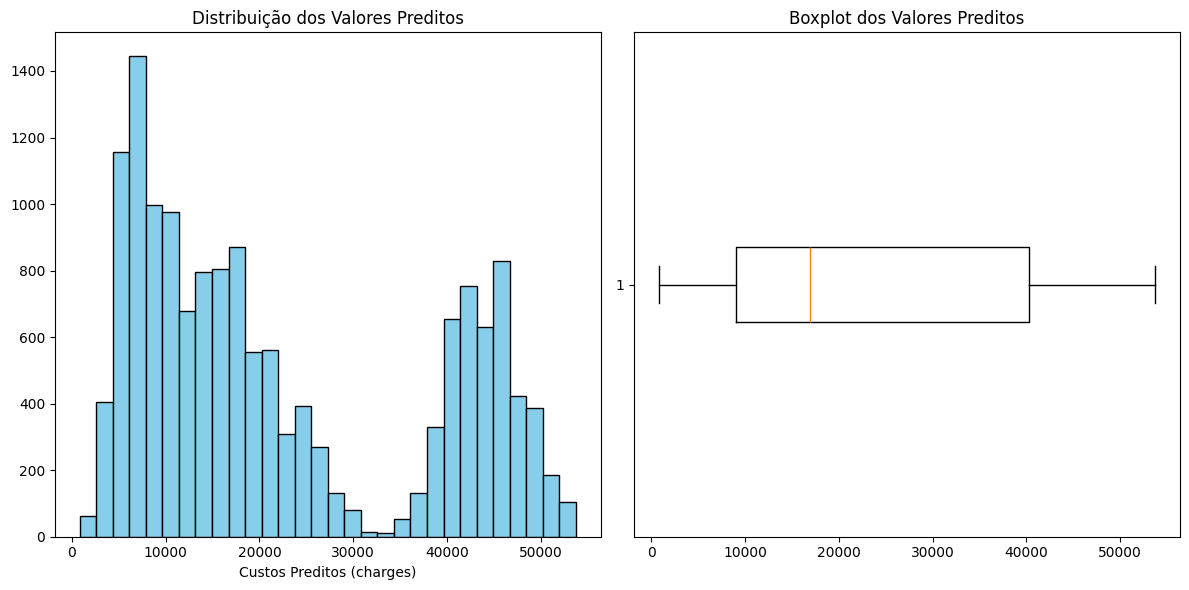


Previsões salvas em 'previsoes_novos_clientes.xlsx'

Amostra das previsões:
        age       bmi  charges_predito
0  0.756572 -0.718542     10588.343750
1 -0.665156  1.764671     44150.308594
2 -0.736243  3.436701     40567.230469
3  0.969832  2.307667     46334.324219
4  1.112004 -0.718542     13693.141602
5  0.472227  2.347398     44882.914062
6 -0.451897  3.699922     42588.175781
7 -0.949502  2.423550      5304.542969
8 -1.304934  0.188658      5290.471191
9 -0.949502  1.221675      5796.997559


In [95]:
# 2. Verificar e preparar os dados novos
X_novos_clientes_df = X_novos_clientes_df[X_train_df.columns]
dnovos = xgb.DMatrix(X_novos_clientes_df)

# 3. Fazer as previsões
previsoes = final_model.predict(dnovos)

# 4. Criar DataFrame com os resultados
resultados = X_novos_clientes_df.copy()
resultados['charges_predito'] = previsoes

# 5. Análise descritiva
print("\n=== ANÁLISE DAS PREVISÕES ===")
print(resultados['charges_predito'].describe())

# 6. Visualização
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(previsoes, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuição dos Valores Preditos')
plt.xlabel('Custos Preditos (charges)')

plt.subplot(1, 2, 2)
plt.boxplot(previsoes, vert=False)
plt.title('Boxplot dos Valores Preditos')
plt.tight_layout()
plt.show()

# 7. Salvar em Excel (ALTERAÇÃO PRINCIPAL)
resultados.to_excel('previsoes_novos_clientes.xlsx', index=False, sheet_name='Previsões')
print("\nPrevisões salvas em 'previsoes_novos_clientes.xlsx'")

# 8. Exibir amostra
print("\nAmostra das previsões:")
print(resultados.head(10)[['age', 'bmi', 'charges_predito']])